In [2]:
# Import libraries with Plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.offline import init_notebook_mode

# Initialize Plotly in notebook mode
init_notebook_mode(connected=True)

# Set up for better display
pd.set_option('display.max_columns', None)

In [3]:
# Load processed data
df = pd.read_csv('../data/processed/final_dataset.csv')

df.rename(columns={
    'GDP_current_US$': 'gdp',
    'Military_expenditure_%_of_GDP': 'mil_exp_pct',
    'Population_total': 'population'
}, inplace=True)

In [4]:
# Calculate total TIV by country to find top importers
importer_ranking = df.groupby('country')['tiv_total_order'].sum().sort_values(ascending=False)

# Get the top 10 importers
top_10_importers = importer_ranking.head(10).index.tolist()

df_top10 = df[df['country'].isin(top_10_importers)].copy()

In [5]:
# Step 1: Dynamically identify top 10 importers
print("IDENTIFYING TOP 10 IMPORTERS AND THEIR SUPPLIERS...")

# Calculate total TIV by country to find top importers
importer_ranking = df.groupby('country')['tiv_total_order'].sum().sort_values(ascending=False)
top_10_importers = importer_ranking.head(10).index.tolist()

print("TOP 10 IMPORTERS (2020-2023):")
for i, (country, tiv) in enumerate(importer_ranking.head(10).items(), 1):
    share = (tiv / importer_ranking.sum()) * 100
    print(f"{i}. {country}: {tiv:,.0f} TIV ({share:.1f}% share)")

# Step 2: Analyze suppliers to these top importers
supplier_analysis = df[df['country'].isin(top_10_importers)].groupby('supplier_country').agg({
    'tiv_total_order': 'sum',
    'country': 'nunique',  # How many top importers they supply
    'weapon_designation': 'count'  # Number of deals
}).rename(columns={
    'country': 'top_importers_served',
    'weapon_designation': 'total_deals'
}).sort_values('tiv_total_order', ascending=False)

print(f"\nTotal suppliers to top 10 importers: {len(supplier_analysis)}")

IDENTIFYING TOP 10 IMPORTERS AND THEIR SUPPLIERS...
TOP 10 IMPORTERS (2020-2023):
1. India: 27,961 TIV (22.2% share)
2. Saudi Arabia: 19,741 TIV (15.7% share)
3. Pakistan: 13,258 TIV (10.5% share)
4. Japan: 12,257 TIV (9.7% share)
5. Qatar: 12,010 TIV (9.5% share)
6. United States: 10,467 TIV (8.3% share)
7. Australia: 8,994 TIV (7.1% share)
8. Egypt: 8,989 TIV (7.1% share)
9. Ukraine: 7,715 TIV (6.1% share)
10. Kuwait: 4,672 TIV (3.7% share)

Total suppliers to top 10 importers: 44



CREATING ENHANCED EXPORTER ANALYSIS...
Displaying enhanced exporter analysis...


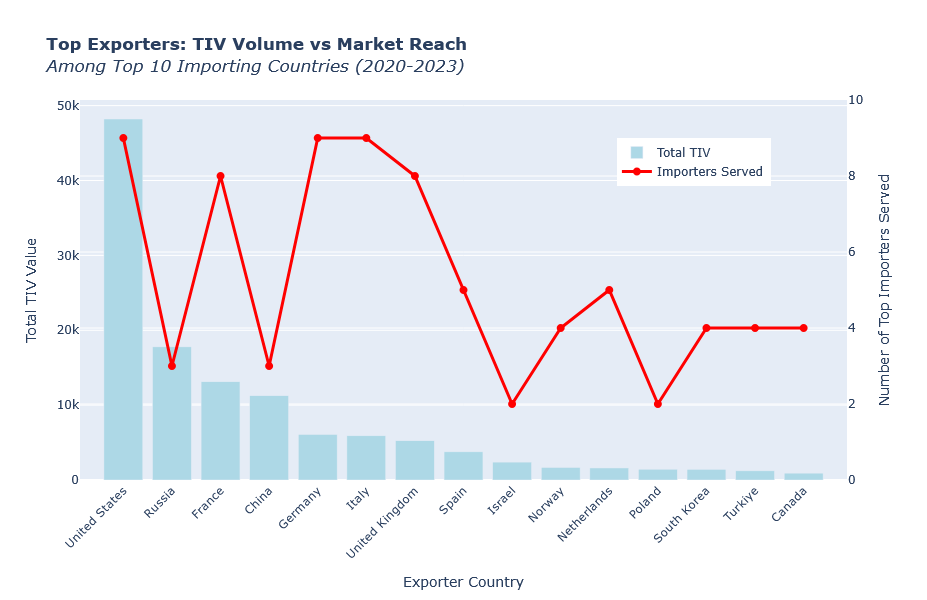

In [6]:
# Step 4: Create an enhanced version with additional metrics
print("\nCREATING ENHANCED EXPORTER ANALYSIS...")

# Calculate market share
total_tiv_top10 = supplier_analysis['tiv_total_order'].sum()
top_exporters_enhanced = supplier_analysis.head(15).copy()
top_exporters_enhanced['market_share'] = (top_exporters_enhanced['tiv_total_order'] / total_tiv_top10) * 100
top_exporters_enhanced = top_exporters_enhanced.reset_index()

# Create enhanced visualization
fig_enhanced = go.Figure()

# Add bar for TIV values
fig_enhanced.add_trace(go.Bar(
    x=top_exporters_enhanced['supplier_country'],
    y=top_exporters_enhanced['tiv_total_order'],
    name='Total TIV',
    marker_color='lightblue',
    hovertemplate="<b>%{x}</b><br>Total TIV: %{y:,.0f}<br>Market Share: %{customdata:.1f}%<extra></extra>",
    customdata=top_exporters_enhanced['market_share']
))

# Add line for number of importers served (secondary axis)
fig_enhanced.add_trace(go.Scatter(
    x=top_exporters_enhanced['supplier_country'],
    y=top_exporters_enhanced['top_importers_served'],
    name='Importers Served',
    mode='lines+markers',
    yaxis='y2',
    line=dict(color='red', width=3),
    marker=dict(size=8),
    hovertemplate="Importers Served: %{y}<extra></extra>"
))

# Update layout for dual axes
fig_enhanced.update_layout(
    title='<b>Top Exporters: TIV Volume vs Market Reach</b><br><i>Among Top 10 Importing Countries (2020-2023)</i>',
    xaxis=dict(title='Exporter Country', tickangle=-45),
    yaxis=dict(title='Total TIV Value', side='left'),
    yaxis2=dict(
        title='Number of Top Importers Served',
        side='right',
        overlaying='y',
        range=[0, top_exporters_enhanced['top_importers_served'].max() + 1]
    ),
    height=600,
    legend=dict(x=0.70, y=0.90)
)

print("Displaying enhanced exporter analysis...")
fig_enhanced.show()

ANALYZING MILITARY EXPENDITURE VS ARMS IMPORTS...


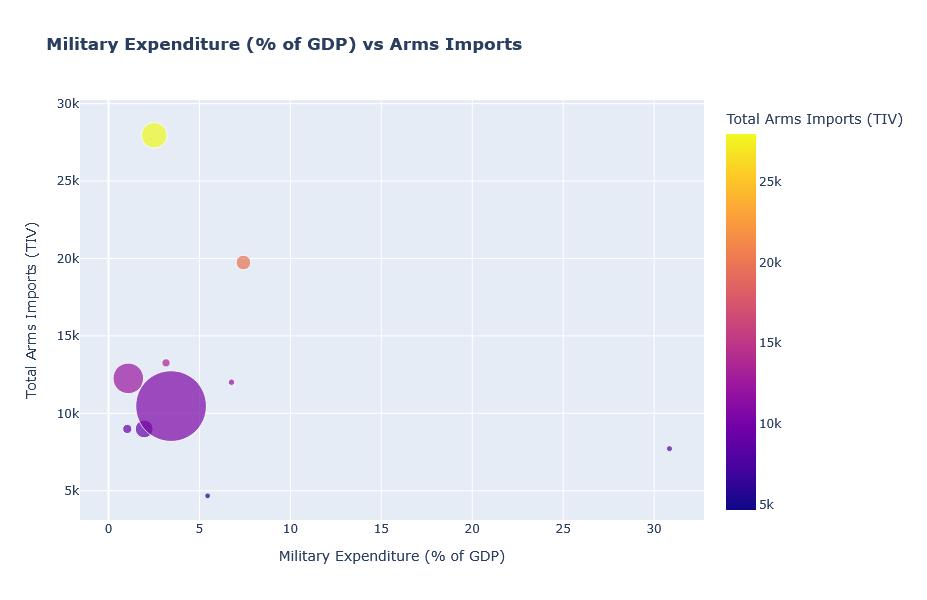

Correlation between military expenditure % and arms imports: -0.229


In [7]:
# Analysis 1: Military Expenditure vs Actual Arms Imports
print("ANALYZING MILITARY EXPENDITURE VS ARMS IMPORTS...")

# Prepare data: Military expenditure % vs actual arms imports
military_analysis = df.groupby('country').agg({
    'tiv_total_order': 'sum',
    'mil_exp_pct': 'mean',  # Average military expenditure %
    'gdp': 'mean',
    'population': 'mean'
}).reset_index()

# Filter for countries with significant imports
military_analysis = military_analysis[military_analysis['tiv_total_order'] > 0]

# Create scatter plot: Military expenditure % vs Arms imports
fig1 = px.scatter(military_analysis, 
                 x='mil_exp_pct', 
                 y='tiv_total_order',
                 size='gdp',
                 hover_name='country',
                 title='<b>Military Expenditure (% of GDP) vs Arms Imports</b>',
                 labels={'mil_exp_pct': 'Military Expenditure (% of GDP)',
                        'tiv_total_order': 'Total Arms Imports (TIV)'},
                 color='tiv_total_order',
                 size_max=50)

fig1.update_layout(height=600)
fig1.show()

# Calculate correlation
correlation = military_analysis['mil_exp_pct'].corr(military_analysis['tiv_total_order'])
print(f"Correlation between military expenditure % and arms imports: {correlation:.3f}")


ANALYZING POPULATION VS ARMS IMPORTS...


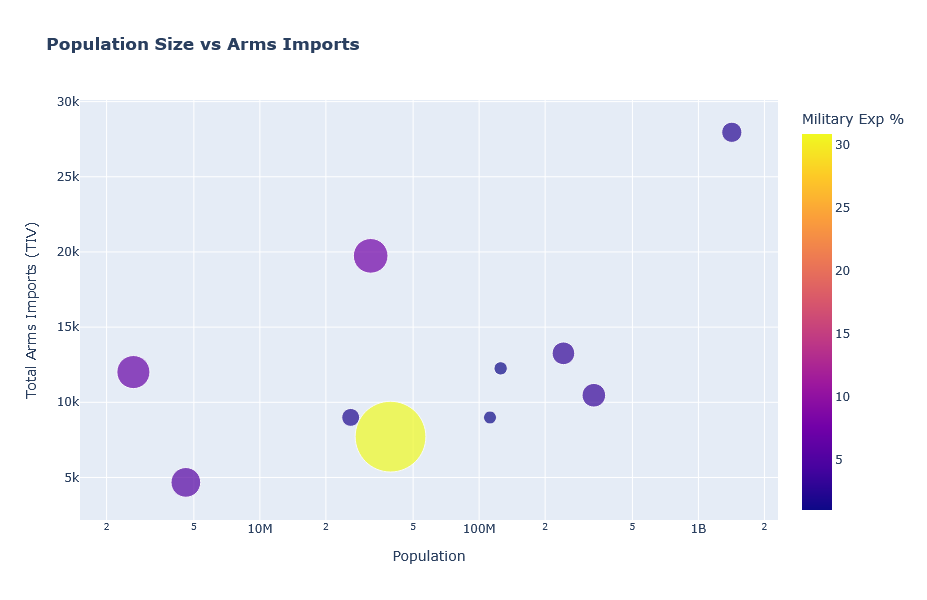


TOP 10 ARMS IMPORTERS PER CAPITA:
         country  imports_per_capita  tiv_total_order    population
6          Qatar            0.004532          12009.7  2.650157e+06
4         Kuwait            0.001016           4671.7  4.596420e+06
7   Saudi Arabia            0.000617          19741.3  3.201318e+07
0      Australia            0.000347           8993.8  2.594961e+07
8        Ukraine            0.000196           7715.0  3.943367e+07
3          Japan            0.000098          12256.9  1.253537e+08
1          Egypt            0.000080           8988.8  1.120790e+08
5       Pakistan            0.000055          13257.7  2.423409e+08
9  United States            0.000031          10467.4  3.335186e+08
2          India            0.000020          27960.6  1.420093e+09


In [8]:
# Analysis 2: Population Size vs Arms Imports
print("\nANALYZING POPULATION VS ARMS IMPORTS...")

# Create population vs imports visualization
fig2 = px.scatter(military_analysis, 
                 x='population', 
                 y='tiv_total_order',
                 size='mil_exp_pct',
                 hover_name='country',
                 title='<b>Population Size vs Arms Imports</b>',
                 labels={'population': 'Population',
                        'tiv_total_order': 'Total Arms Imports (TIV)',
                        'mil_exp_pct': 'Military Exp %'},
                 color='mil_exp_pct',
                 log_x=True,  # Log scale for better visualization
                 size_max=50)

fig2.update_layout(height=600)
fig2.show()

# Per capita analysis
military_analysis['imports_per_capita'] = military_analysis['tiv_total_order'] / military_analysis['population']
military_analysis['imports_per_capita_gdp'] = military_analysis['tiv_total_order'] / military_analysis['gdp']

# Top importers per capita
top_per_capita = military_analysis.nlargest(10, 'imports_per_capita')
print("\nTOP 10 ARMS IMPORTERS PER CAPITA:")
print(top_per_capita[['country', 'imports_per_capita', 'tiv_total_order', 'population']])

In [9]:
# Analysis 3: Deal Status Patterns
print("\nANALYZING DEAL STATUS PATTERNS...")

# Analyze deal status distribution
deal_status_analysis = df.groupby('deal_status').agg({
    'tiv_total_order': 'sum',
    'units_ordered': 'sum',
    'country': 'count'
}).rename(columns={'country': 'number_of_deals'}).sort_values('tiv_total_order', ascending=False)

print("DEAL STATUS BREAKDOWN:")
print(deal_status_analysis)

# Create deal status visualization
fig3 = px.pie(deal_status_analysis.reset_index(),
             values='tiv_total_order',
             names='deal_status',
             title='<b>Arms Deal Status Distribution (TIV Value)</b>',
             hover_data=['number_of_deals'])

fig3.update_traces(textposition='inside', textinfo='percent+label')
fig3.show()

# Deal status by year (trend analysis)
if 'order_year' in df.columns:
    deal_status_trend = df.groupby(['order_year', 'deal_status']).agg({
        'tiv_total_order': 'sum'
    }).reset_index()
    
    fig4 = px.line(deal_status_trend,
                  x='order_year',
                  y='tiv_total_order',
                  color='deal_status',
                  title='<b>Deal Status Trends Over Time</b>',
                  labels={'order_year': 'Year', 'tiv_total_order': 'TIV Value'})
    
    fig4.show()


ANALYZING DEAL STATUS PATTERNS...
DEAL STATUS BREAKDOWN:
                            tiv_total_order  units_ordered  number_of_deals
deal_status                                                                
New                                119337.4       192991.7              982
Second hand                          6628.9        30307.1              355
Second hand but modernized             96.6          167.0                8



COMPREHENSIVE ECONOMIC-MILITARY ANALYSIS...


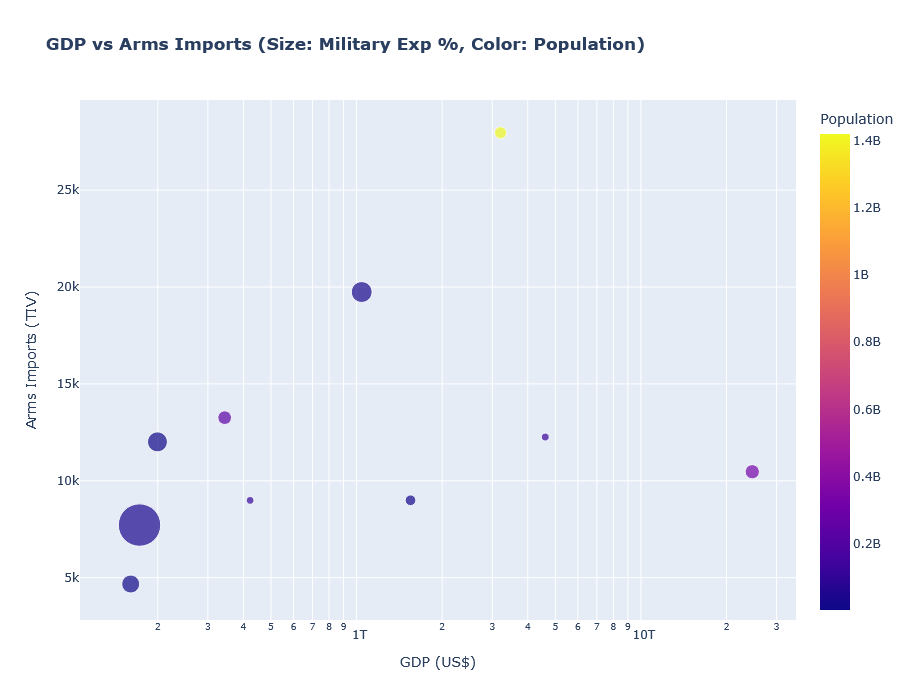


MOST EFFICIENT ARMS IMPORTERS (Highest imports per military expenditure %):
         country  efficiency_score  tiv_total_order  mil_exp_pct
3          Japan      11261.871092          12256.9     1.088354
2          India      11121.636174          27960.6     2.514073
1          Egypt       8705.215546           8988.8     1.032576
0      Australia       4580.549923           8993.8     1.963476
5       Pakistan       4192.262687          13257.7     3.162421
9  United States       3042.381985          10467.4     3.440528
7   Saudi Arabia       2661.650488          19741.3     7.416939
6          Qatar       1776.290149          12009.7     6.761114
4         Kuwait        857.295952           4671.7     5.449343
8        Ukraine        250.121302           7715.0    30.845034


In [10]:
# Analysis 4: Integrated Economic-Military Analysis
print("\nCOMPREHENSIVE ECONOMIC-MILITARY ANALYSIS...")

# Create a bubble chart with multiple dimensions
fig5 = px.scatter(military_analysis,
                 x='gdp',
                 y='tiv_total_order',
                 size='mil_exp_pct',
                 color='population',
                 hover_name='country',
                 title='<b>GDP vs Arms Imports (Size: Military Exp %, Color: Population)</b>',
                 labels={'gdp': 'GDP (US$)',
                        'tiv_total_order': 'Arms Imports (TIV)',
                        'mil_exp_pct': 'Military Exp %',
                        'population': 'Population'},
                 log_x=True,
                 size_max=30)

fig5.update_layout(height=700)
fig5.show()

# Calculate key metrics
military_analysis['arms_to_gdp_ratio'] = (military_analysis['tiv_total_order'] / military_analysis['gdp']) * 1000000
military_analysis['efficiency_score'] = military_analysis['tiv_total_order'] / military_analysis['mil_exp_pct']

print("\nMOST EFFICIENT ARMS IMPORTERS (Highest imports per military expenditure %):")
efficient_importers = military_analysis[military_analysis['mil_exp_pct'] > 0].nlargest(10, 'efficiency_score')
print(efficient_importers[['country', 'efficiency_score', 'tiv_total_order', 'mil_exp_pct']])

In [11]:
# Export with proper distinction between order and delivery years
tableau_export = df[[
    'country',           # Recipient
    'supplier_country',  # Supplier
    'order_year',        # When ordered
    'year',              # When delivered/will deliver (CRUCIAL!)
    'tiv_total_order',   # Total contract value
    'tiv_delivered',     # Value actually delivered (CRUCIAL!)
    'units_ordered',     # Units ordered
    'units_delivered',   # Units actually delivered (CRUCIAL!)
    'weapon_designation',# Weapon type
    'deal_status',       # Order status
    'gdp',               # Economic indicator
    'mil_exp_pct',       # Military spending
    'population'         # Population
]].copy()

# Create helpful calculated fields
tableau_export['delivery_timeline_years'] = tableau_export['year'] - tableau_export['order_year']
tableau_export['delivery_status'] = tableau_export['deal_status']
tableau_export['pending_tiv'] = tableau_export['tiv_total_order'] - tableau_export['tiv_delivered']
tableau_export['completion_rate'] = (tableau_export['tiv_delivered'] / tableau_export['tiv_total_order']).fillna(0)

print("Enhanced Tableau export with delivery timeline analysis:")
print(f"✅ Order year vs Delivery year distinction preserved")
print(f"✅ Delivery timeline calculations added") 
print(f"✅ Completion rates calculated")
print(f"✅ Pending/backlog values included")

tableau_export.to_csv('arms_trade_enhanced_tableau.csv', index=False)

Enhanced Tableau export with delivery timeline analysis:
✅ Order year vs Delivery year distinction preserved
✅ Delivery timeline calculations added
✅ Completion rates calculated
✅ Pending/backlog values included
